In [695]:
# --- Importe suas classes ---
# (Assumindo que estão no PYTHONPATH ou na mesma pasta)
from equation.option_pricing import BlackScholes
from optimize.option_princing import BlackScholeOptimizer
from method.nn import MLP, ResNet
from method.hnn import HybridCQN 
from method.qnn import QuantumNeuralNetwork
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch as tc
import torch.nn as nn
import numpy as np
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils.save import *



In [696]:
# =============================================================================
# 0. CONFIGURAÇÃO
# =============================================================================

# Métrica principal para avaliar os modelos (use a desnormalizada)
MSE_COLUMN = 'mse_teste_desnormalizado'
LOSS_COLUMN = 'mean_last_100_loss' # ou 'mean_last_100_loss'

# Constantes de normalização (as mesmas usadas no treino)
S_max = 160.0
T = 1.0
V_max = 140.0

In [697]:
# =============================================================================
# 1. CARREGAR OS DADOS DO SUMÁRIO
# =============================================================================

all_dfs = []
summary = [SUMMARY_CLASSIC_PATH, SUMMARY_HYBRID_PATH, SUMMARY_QUANTUM_PATH, SUMMARY_CQUANTUM_PATH, SUMMARY_CHYBRID_PATH]

for summar in summary:
    all_dfs.append(pd.read_csv(summar))


df_all = pd.concat(all_dfs, ignore_index=True)

valid_seeds = [1924, 1925, 1926, 1973, 2024]
df_all = df_all[
    (df_all["seed"].isin(valid_seeds))  # filtragem pelas seeds
]

In [698]:
df_class = df_all[
    (df_all["model_type"] == "MLP") &
    (df_all["hidden"].isin([2, 3, 5, 10, 20])) &
    (df_all["blocks"].isin([1, 3, 5, 10, 20]))
    ].drop_duplicates()

df_class = df_class.drop_duplicates(subset=["hidden", "blocks", "seed"])

df_hybrid = df_all[(df_all["model_type"] == "HQNN") &
    (df_all["n_qubits"] == 5) &
    (df_all["entangler"] == "strong") &
    (df_all["n_layers"].isin([1, 3, 5]))
    ].drop_duplicates()

df_hybrid = df_hybrid.drop_duplicates(subset=["hidden", "blocks", "seed", "n_qubits", "n_layers"])

#df_hybrid = df_hybrid.drop_duplicates(subset=["hidden", "blocks", "seed"])

df_quantum = df_all[
    (df_all["model_type"] == "QNN") &
    (df_all["n_qubits"] == 5) &
    (df_all["entangler"] == "strong")
    ].drop_duplicates()   


df_quantum = df_quantum.drop_duplicates(subset=["hidden", "blocks", "seed", "n_qubits", "n_layers"])

In [699]:
df_hybrid

,model_type,run_id_prefix,lr,epochs,activation,hidden,blocks,seed,run_id,mse_teste_normalizado,...,model_path,loss_history_path,final_total_loss,mean_last_100_loss,model_class,entangler,n_qubits,n_layers,k,n_vertex
829,HQNN,hqnn_strong_mlp,0.002,15000.0,Tanh(),3.0,1.0,1924.0,hqnn_strong_mlp_n_3_b_1_n_qubits_5_n_l_1_seed_...,0.000053,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000073,0.000076,MLP,strong,5.0,1.0,NaN,NaN
830,HQNN,hqnn_strong_mlp,0.002,15000.0,Tanh(),3.0,1.0,1925.0,hqnn_strong_mlp_n_3_b_1_n_qubits_5_n_l_1_seed_...,0.000013,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000020,0.000024,MLP,strong,5.0,1.0,NaN,NaN
831,HQNN,hqnn_strong_mlp,0.002,15000.0,Tanh(),3.0,1.0,1926.0,hqnn_strong_mlp_n_3_b_1_n_qubits_5_n_l_1_seed_...,0.000109,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000148,0.000151,MLP,strong,5.0,1.0,NaN,NaN
832,HQNN,hqnn_strong_mlp,0.002,15000.0,Tanh(),3.0,1.0,1973.0,hqnn_strong_mlp_n_3_b_1_n_qubits_5_n_l_1_seed_...,0.000007,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000008,0.000010,MLP,strong,5.0,1.0,NaN,NaN
833,HQNN,hqnn_strong_mlp,0.002,15000.0,Tanh(),3.0,1.0,2024.0,hqnn_strong_mlp_n_3_b_1_n_qubits_5_n_l_1_seed_...,0.000041,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000060,0.000065,MLP,strong,5.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,HQNN,hqnn_strong_mlp,0.002,15000.0,Tanh(),3.0,5.0,1973.0,hqnn_strong_mlp_n_3_b_5_n_qubits_5_n_l_5_seed_...,0.000008,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000007,0.000015,MLP,strong,5.0,5.0,NaN,NaN
1298,HQNN,hqnn_strong_mlp,0.002,15000.0,Tanh(),3.0,5.0,1926.0,hqnn_strong_mlp_n_3_b_5_n_qubits_5_n_l_5_seed_...,0.000009,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000011,0.000011,MLP,strong,5.0,5.0,NaN,NaN
1300,HQNN,hqnn_strong_mlp,0.002,15000.0,Tanh(),3.0,5.0,1926.0,hqnn_strong_mlp_n_3_b_5_n_qubits_5_n_l_3_seed_...,0.000006,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000005,0.000019,MLP,strong,5.0,3.0,NaN,NaN
1301,HQNN,hqnn_strong_mlp,0.002,15000.0,Tanh(),3.0,5.0,1973.0,hqnn_strong_mlp_n_3_b_5_n_qubits_5_n_l_3_seed_...,0.000006,...,experimentos_pinn/modelos_salvos/modelo_hqnn_s...,experimentos_pinn/historicos_loss/loss_hqnn_st...,0.000002,0.000002,MLP,strong,5.0,3.0,NaN,NaN


In [700]:
df_class.groupby(["hidden", "blocks"]).size()


hidden  blocks
2.0     1.0       5
        3.0       5
        5.0       5
        10.0      5
3.0     1.0       5
        3.0       5
        5.0       5
        10.0      5
5.0     1.0       5
        3.0       5
        5.0       5
        10.0      5
10.0    1.0       5
        3.0       5
        5.0       5
        10.0      5
20.0    1.0       5
        3.0       5
        5.0       5
        10.0      5
dtype: int64

In [701]:
MAX_VAL = -3.4
MIN_VAL = -5.5


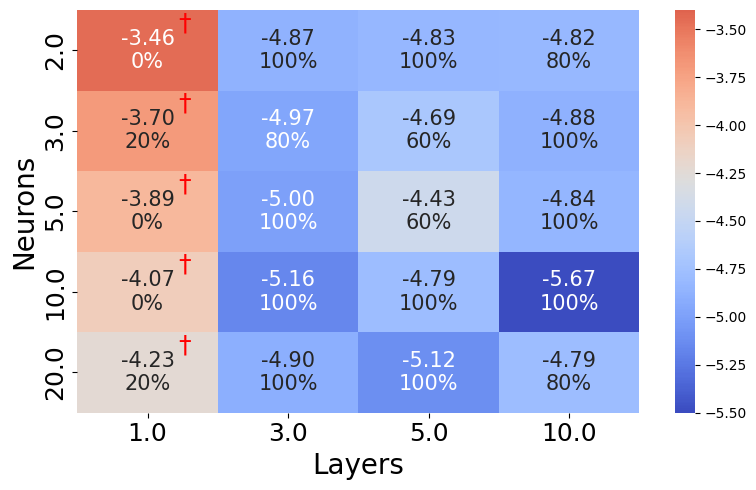

In [702]:
threshold = (1 / 140**2)

# =======================
# 1) Tabela com a MÉDIA
# =======================
pivot = df_class.pivot_table(
    index="hidden",
    columns="blocks",
    values=LOSS_COLUMN,
    aggfunc="median"
)

# log10 dos valores
pivot_log = np.log10(pivot)

# =======================
# 2) Tabela com % de CONVERGÊNCIA
#    (fração de runs com loss < threshold)
# =======================
conv_pivot = (
    df_class
    .groupby(["hidden", "blocks"])[LOSS_COLUMN]
    .apply(lambda x: 100 * np.mean(x < threshold))
    .unstack("blocks")
)

# =======================
# 3) Matriz de strings para o annot
#    "valor\nXX%"
# =======================
annot = np.empty_like(pivot_log.values, dtype=object)

for i, h in enumerate(pivot.index):
    for j, b in enumerate(pivot.columns):
        val = pivot_log.loc[h, b]
        conv = conv_pivot.loc[h, b] if (h in conv_pivot.index and b in conv_pivot.columns) else np.nan
        if np.isnan(conv):
            annot[i, j] = f"{val:.2f}\n-"
        else:
            annot[i, j] = f"{val:.2f}\n{conv:.0f}%"

# log10 do threshold para centralizar o mapa
thr_log = np.log10(threshold)

plt.figure(figsize=(8,5))
ax = sns.heatmap(
    pivot_log,
    annot=annot,
    fmt="",              # importante: usamos strings prontas
    cmap="coolwarm",
    center=thr_log,
    vmin = MIN_VAL,
    vmax = MAX_VAL,
    annot_kws={"size": 15},
)
ax.tick_params(axis='both', which='major', labelsize=18)
#plt.title(f"log10(MSE normalizado) — threshold = {threshold}")
plt.ylabel("Neurons", fontsize=20)
plt.xlabel("Layers", fontsize=20)

# === adicionar '†' no canto superior direito das células acima do threshold ===
for i in range(pivot.shape[0]):        # linhas
    for j in range(pivot.shape[1]):    # colunas
        if pivot.iloc[i, j] > threshold:
            ax.text(
                j + 0.72,   # x deslocado para o canto superior direito
                i + 0.25,   # y deslocado levemente para cima
                "$\\dagger$",
                color="red",
                fontsize=18,
                fontweight="bold"
            )

plt.tight_layout()
plt.savefig("weciq_classic_heatmap.png", dpi=300)
plt.show()


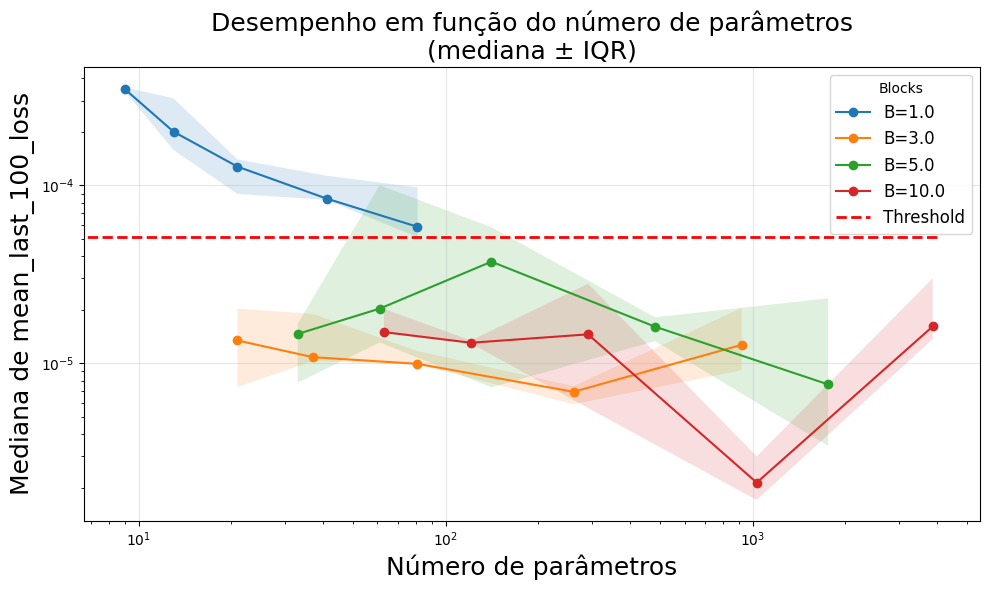

In [703]:
# ======================================================
# 1) AGRUPAMENTO POR (blocks, num_params)
#    -> mediana
#    -> IQR (Q1 e Q3)
# ======================================================

df_stats = df_class.groupby(["blocks", "num_params"])[LOSS_COLUMN].agg(
    median = "median",
    q1     = lambda x: np.percentile(x, 25),
    q3     = lambda x: np.percentile(x, 75)
).reset_index()

# limites inferior/superior da banda
df_stats["lower"] = df_stats["q1"]
df_stats["upper"] = df_stats["q3"]

# evitar valores negativos em escala log
df_stats["lower"] = df_stats["lower"].clip(lower=1e-12)


# ======================================================
# 2) PLOT — cada valor de blocks vira uma linha
# ======================================================

plt.figure(figsize=(10,6))

blocks_values = sorted(df_stats["blocks"].unique())

for L in blocks_values:
    sub = df_stats[df_stats["blocks"] == L].sort_values("num_params")

    x = sub["num_params"].values
    y = sub["median"].values
    low = sub["lower"].values
    upp = sub["upper"].values

    # linha + banda IQR
    plt.plot(x, y, marker="o", label=f"B={L}")
    plt.fill_between(x, low, upp, alpha=0.15)

xmin, xmax = plt.xlim()

plt.hlines(
    y=threshold,
    xmin=xmin,
    xmax=xmax,
    colors='r',
    linestyles='--',
    linewidth=2,
    label='Threshold'
)

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Número de parâmetros", fontsize=18)
plt.ylabel(f"Mediana de {LOSS_COLUMN}", fontsize=18)
plt.title("Desempenho em função do número de parâmetros\n(mediana ± IQR)", fontsize=18)
plt.legend(title="Blocks", fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


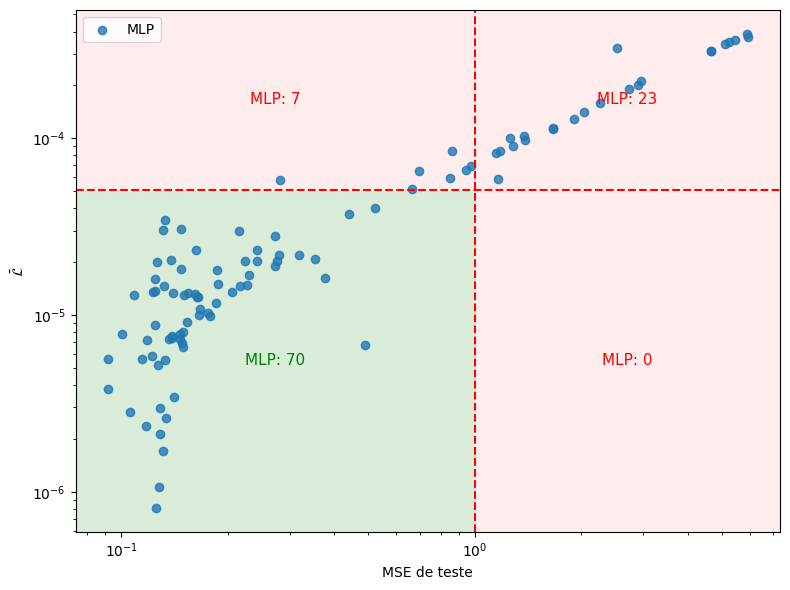

In [704]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ==========================
# CONFIGURAÇÕES
# ==========================
MSE_COLUMN = "mse_teste_desnormalizado"   # ajuste se o nome for outro
# LOSS_COLUMN já deve estar definido no seu código

# threshold em x e y
tx = 1.0                    # threshold em MSE
ty = 1 / 140**2             # threshold em loss

# -----------------------------
# dados: um único modelo (df_class)
# -----------------------------
x = df_class[MSE_COLUMN].values
y = df_class[LOSS_COLUMN].values

# -----------------------------
# função p/ contagem de quadrantes
# -----------------------------
def quadrant_counts(x, y, tx, ty):
    x = np.asarray(x); y = np.asarray(y)
    return {
        "Q1": np.sum((x >= tx) & (y >= ty)),  # cima-direita
        "Q2": np.sum((x <  tx) & (y >= ty)),  # cima-esquerda
        "Q3": np.sum((x <  tx) & (y <  ty)),  # baixo-esquerda (região boa)
        "Q4": np.sum((x >= tx) & (y <  ty)),  # baixo-direita
    }

cnt = quadrant_counts(x, y, tx, ty)

# -----------------------------
# plot
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(x, y, label="MLP", alpha=0.8)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("MSE de teste")
ax.set_ylabel(r"$\bar{\mathcal{L}}$")

# linhas de threshold
ax.axhline(ty, color='red', linestyle='--', linewidth=1.5)
ax.axvline(tx, color='red', linestyle='--', linewidth=1.5)

# limites (depois de plottar e setar log!)
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

# -----------------------------
# quadrantes com Rectangle
# -----------------------------
# quadrante bom (baixo-esquerda) – verde
ax.add_patch(Rectangle(
    (x_min, y_min),           # canto inferior esquerdo
    tx - x_min,               # largura
    ty - y_min,               # altura
    facecolor='green', alpha=0.15, zorder=0
))

# cima-esquerda – vermelho claro
ax.add_patch(Rectangle(
    (x_min, ty),
    tx - x_min,
    y_max - ty,
    facecolor='red', alpha=0.07, zorder=0
))

# baixo-direita – vermelho claro
ax.add_patch(Rectangle(
    (tx, y_min),
    x_max - tx,
    ty - y_min,
    facecolor='red', alpha=0.07, zorder=0
))

# cima-direita – vermelho claro
ax.add_patch(Rectangle(
    (tx, ty),
    x_max - tx,
    y_max - ty,
    facecolor='red', alpha=0.07, zorder=0
))

# garantir que limites não mudem
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# -----------------------------
# posições dos textos (meio geométrico em log)
# -----------------------------
def mid_log(a, b):
    return 10**((np.log10(a) + np.log10(b)) / 2)

xL = mid_log(x_min, tx)
xR = mid_log(tx,   x_max)
yB = mid_log(y_min, ty)
yT = mid_log(ty,    y_max)

# baixo-esquerda (Q3) – verde (região boa)
ax.text(
    xL, yB,
    f"MLP: {cnt['Q3']}",
    color='green', fontsize=11, ha='center', va='center'
)

# cima-esquerda (Q2) – vermelho
ax.text(
    xL, yT,
    f"MLP: {cnt['Q2']}",
    color='red', fontsize=11, ha='center', va='center'
)

# baixo-direita (Q4) – vermelho
ax.text(
    xR, yB,
    f"MLP: {cnt['Q4']}",
    color='red', fontsize=11, ha='center', va='center'
)

# cima-direita (Q1) – vermelho
ax.text(
    xR, yT,
    f"MLP: {cnt['Q1']}",
    color='red', fontsize=11, ha='center', va='center'
)

ax.legend()
plt.tight_layout()
plt.show()


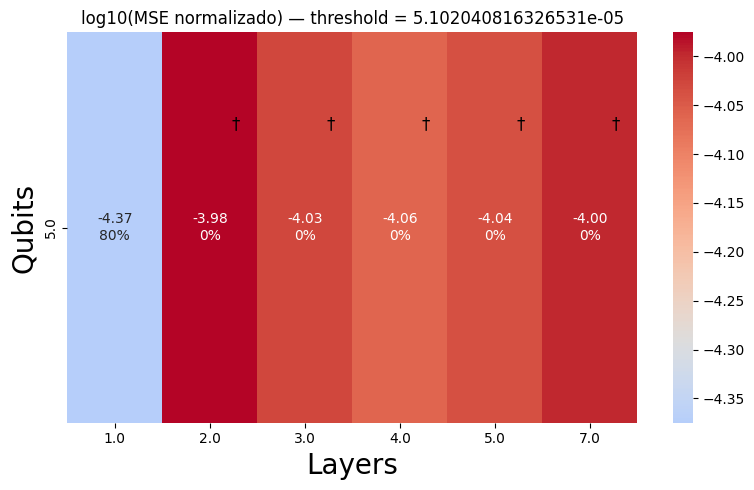

In [705]:
threshold = (1 / 140**2)

# =======================
# 1) Tabela com a MÉDIA
# =======================
pivot = df_quantum.pivot_table(
    index="n_qubits",
    columns="n_layers",
    values=LOSS_COLUMN,
    aggfunc="median"
)

# log10 dos valores
pivot_log = np.log10(pivot)

# =======================
# 2) Tabela com % de CONVERGÊNCIA
#    (fração de runs com loss < threshold)
# =======================
conv_pivot = (
    df_quantum
    .groupby(["n_qubits", "n_layers"])[LOSS_COLUMN]
    .apply(lambda x: 100 * np.mean(x < threshold))
    .unstack("n_layers")
)

# =======================
# 3) Matriz de strings para o annot
#    "valor\nXX%"
# =======================
annot = np.empty_like(pivot_log.values, dtype=object)

for i, h in enumerate(pivot.index):
    for j, b in enumerate(pivot.columns):
        val = pivot_log.loc[h, b]
        conv = conv_pivot.loc[h, b] if (h in conv_pivot.index and b in conv_pivot.columns) else np.nan
        if np.isnan(conv):
            annot[i, j] = f"{val:.2f}\n-"
        else:
            annot[i, j] = f"{val:.2f}\n{conv:.0f}%"

# log10 do threshold para centralizar o mapa
thr_log = np.log10(threshold)

plt.figure(figsize=(8,5))
ax = sns.heatmap(
    pivot_log,
    annot=annot,
    fmt="",              # importante: usamos strings prontas
    cmap="coolwarm",
    center=thr_log,
)

plt.title(f"log10(MSE normalizado) — threshold = {threshold}")
plt.ylabel("Qubits", fontsize=20)
plt.xlabel("Layers", fontsize=20)

# === adicionar '†' no canto superior direito das células acima do threshold ===
for i in range(pivot.shape[0]):        # linhas
    for j in range(pivot.shape[1]):    # colunas
        if pivot.iloc[i, j] > threshold:
            ax.text(
                j + 0.72,   # x deslocado para o canto superior direito
                i + 0.25,   # y deslocado levemente para cima
                "$\\dagger$",
                color="black",
                fontsize=12,
                fontweight="bold"
            )

plt.tight_layout()
plt.show()


In [706]:
# pega um par qualquer (primeiro da tabela)
h = pivot.index[0]          # um valor de n_qubits
b = pivot.columns[0]        # um valor de n_layers

print(f"\n>>> Checando célula (qubits={h}, layers={b})")

# --- valores brutos de loss nesse par ---
vals_q = df_quantum[
    (df_quantum["n_qubits"] == h) &
    (df_quantum["n_layers"] == b)
][LOSS_COLUMN].values

print("loss brutos (df_quantum):", vals_q)

# mediana calculada diretamente
med_manual = np.median(vals_q)
print("mediana manual:", med_manual)
print("mediana no pivot:", pivot.loc[h, b])

# --- se quiser calcular também a % de convergência nesse mesmo conjunto: ---
conv_manual = 100 * np.mean(vals_q < threshold)
print(f"% convergência manual (df_quantum): {conv_manual:.1f}%")

# se conv_pivot tiver mesma indexação de h, b:
if (h in conv_pivot.index) and (b in conv_pivot.columns):
    print("valor em conv_pivot:", conv_pivot.loc[h, b])
else:
    print("par (h,b) não existe em conv_pivot (índices diferentes).")



>>> Checando célula (qubits=5.0, layers=1.0)
loss brutos (df_quantum): [4.21806009e-05 4.05639129e-05 1.69361982e-05 1.82861112e-04
 4.39924621e-05]
mediana manual: 4.218060090352082e-05
mediana no pivot: 4.218060090352082e-05
% convergência manual (df_quantum): 80.0%
valor em conv_pivot: 80.0


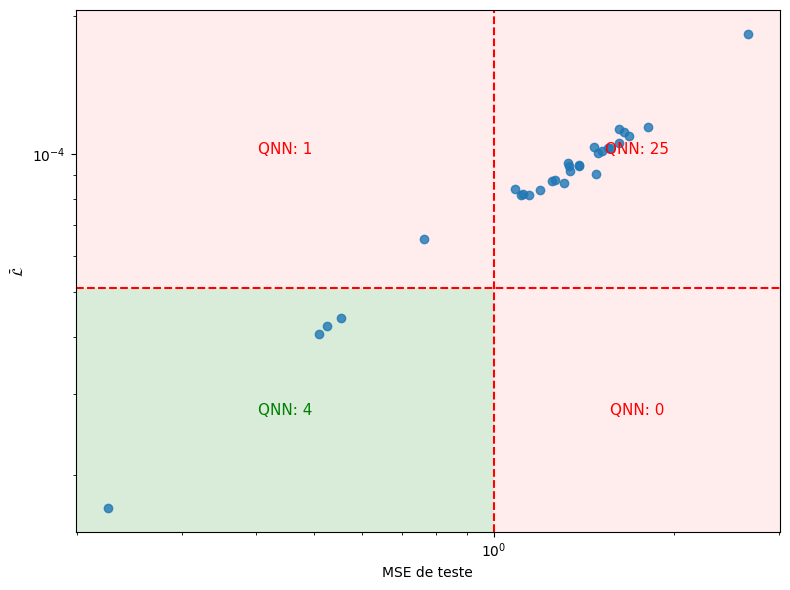

In [707]:
# ==========================
# CONFIGURAÇÕES
# ==========================
MSE_COLUMN = "mse_teste_desnormalizado"   # ajuste se o nome for outro
# LOSS_COLUMN já deve estar definido no seu código

# threshold em x e y
tx = 1.0                    # threshold em MSE
ty = 1 / 140**2             # threshold em loss

# -----------------------------
# dados: um único modelo (df_class)
# -----------------------------
x = df_quantum[MSE_COLUMN].values
y = df_quantum[LOSS_COLUMN].values

# -----------------------------
# função p/ contagem de quadrantes
# -----------------------------

cnt = quadrant_counts(x, y, tx, ty)

# -----------------------------
# plot
# -----------------------------
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(x, y, label="MLP", alpha=0.8)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("MSE de teste")
ax.set_ylabel(r"$\bar{\mathcal{L}}$")

# linhas de threshold
ax.axhline(ty, color='red', linestyle='--', linewidth=1.5)
ax.axvline(tx, color='red', linestyle='--', linewidth=1.5)

# limites (depois de plottar e setar log!)
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

# -----------------------------
# quadrantes com Rectangle
# -----------------------------
# quadrante bom (baixo-esquerda) – verde
ax.add_patch(Rectangle(
    (x_min, y_min),           # canto inferior esquerdo
    tx - x_min,               # largura
    ty - y_min,               # altura
    facecolor='green', alpha=0.15, zorder=0
))

# cima-esquerda – vermelho claro
ax.add_patch(Rectangle(
    (x_min, ty),
    tx - x_min,
    y_max - ty,
    facecolor='red', alpha=0.07, zorder=0
))

# baixo-direita – vermelho claro
ax.add_patch(Rectangle(
    (tx, y_min),
    x_max - tx,
    ty - y_min,
    facecolor='red', alpha=0.07, zorder=0
))

# cima-direita – vermelho claro
ax.add_patch(Rectangle(
    (tx, ty),
    x_max - tx,
    y_max - ty,
    facecolor='red', alpha=0.07, zorder=0
))

# garantir que limites não mudem
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# -----------------------------
# posições dos textos (meio geométrico em log)
# -----------------------------
def mid_log(a, b):
    return 10**((np.log10(a) + np.log10(b)) / 2)

xL = mid_log(x_min, tx)
xR = mid_log(tx,   x_max)
yB = mid_log(y_min, ty)
yT = mid_log(ty,    y_max)

# baixo-esquerda (Q3) – verde (região boa)
ax.text(
    xL, yB,
    f"QNN: {cnt['Q3']}",
    color='green', fontsize=11, ha='center', va='center'
)

# cima-esquerda (Q2) – vermelho
ax.text(
    xL, yT,
    f"QNN: {cnt['Q2']}",
    color='red', fontsize=11, ha='center', va='center'
)

# baixo-direita (Q4) – vermelho
ax.text(
    xR, yB,
    f"QNN: {cnt['Q4']}",
    color='red', fontsize=11, ha='center', va='center'
)

# cima-direita (Q1) – vermelho
ax.text(
    xR, yT,
    f"QNN: {cnt['Q1']}",
    color='red', fontsize=11, ha='center', va='center'
)

#ax.legend()
plt.tight_layout()
plt.show()


In [708]:
df_hybrid.groupby(["hidden", "blocks",  "n_layers"]).size()


hidden  blocks  n_layers
2.0     1.0     1.0         5
                3.0         5
                5.0         5
        3.0     1.0         5
                3.0         5
                5.0         5
        5.0     1.0         5
                3.0         5
                5.0         5
3.0     1.0     1.0         5
                3.0         5
                5.0         5
        3.0     1.0         5
                3.0         5
                5.0         5
        5.0     1.0         5
                3.0         5
                5.0         5
5.0     1.0     1.0         5
                3.0         5
                5.0         5
        3.0     1.0         5
                3.0         5
                5.0         5
        5.0     1.0         5
                3.0         5
                5.0         5
dtype: int64


=== Gerando heatmap para n_layers = 1.0 ===


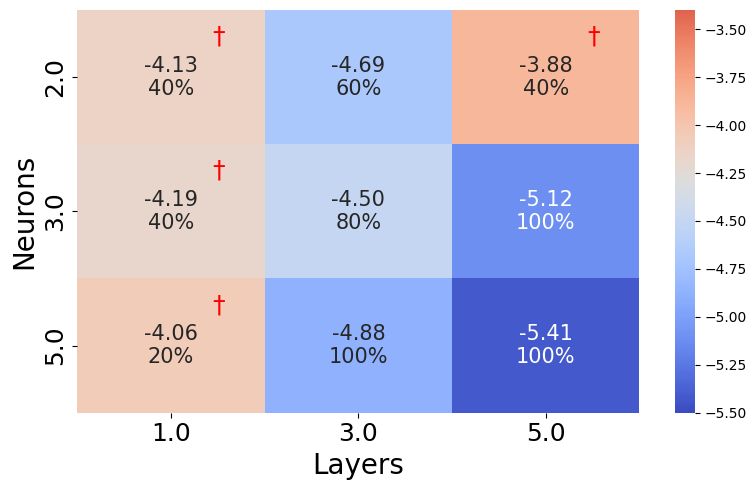


=== Gerando heatmap para n_layers = 3.0 ===


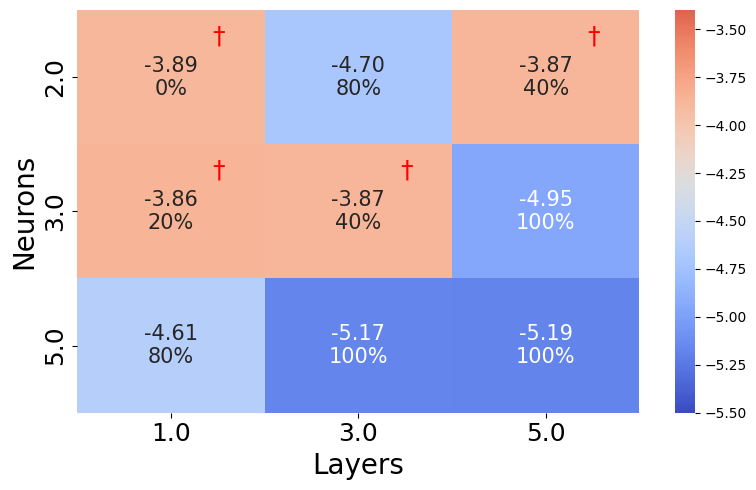


=== Gerando heatmap para n_layers = 5.0 ===


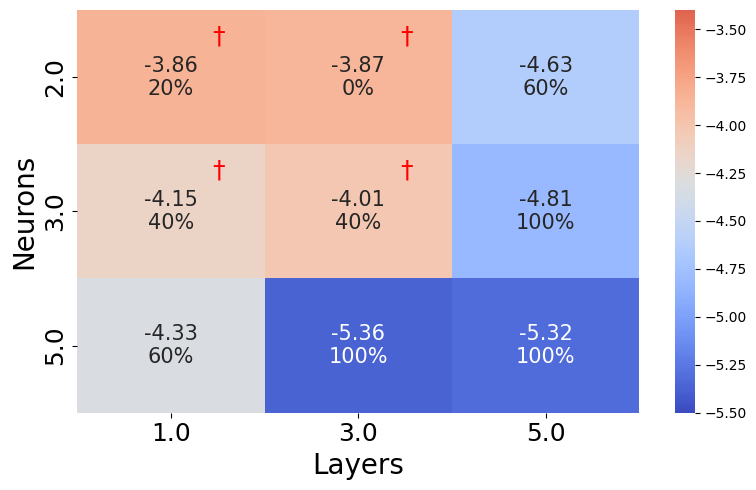

In [709]:
nq_fix = 5     # fixado
threshold = (1 / 140**2)

# -------------------------------
# 1. valores de layers disponíveis
# -------------------------------
all_layers = sorted(df_hybrid["n_layers"].unique())

# -------------------------------
# 2. Loop para cada n_layers
# -------------------------------
for nl_fix in all_layers:

    print(f"\n=== Gerando heatmap para n_layers = {nl_fix} ===")

    # =======================================
    # Filtra só o conjunto de qubits e layers
    # =======================================
    df_q = df_hybrid[
        (df_hybrid["n_qubits"] == nq_fix) &
        (df_hybrid["n_layers"] == nl_fix)
    ].copy()

    if df_q.empty:
        print(f"Sem dados para n_layers={nl_fix}")
        continue

    # =======================================
    # Tabela com a MÉDIA
    # =======================================
    pivot = df_q.pivot_table(
        index="hidden",
        columns="blocks",
        values=LOSS_COLUMN,
        aggfunc="median"
    )

    pivot_log = np.log10(pivot)

    # =======================================
    # % de convergência
    # =======================================
    conv_pivot = (
        df_q
        .groupby(["hidden", "blocks"])[LOSS_COLUMN]
        .apply(lambda x: 100 * np.mean(x < threshold))
        .unstack("blocks")
    )

    # =======================================
    # Construção das anotações log10 + %
    # =======================================
    annot = np.empty_like(pivot_log.values, dtype=object)

    for i, h in enumerate(pivot.index):
        for j, b in enumerate(pivot.columns):
            val = pivot_log.loc[h, b]
            conv = (
                conv_pivot.loc[h, b]
                if (h in conv_pivot.index and b in conv_pivot.columns)
                else np.nan
            )
            if np.isnan(conv):
                annot[i, j] = f"{val:.2f}\n-"
            else:
                annot[i, j] = f"{val:.2f}\n{conv:.0f}%"

    thr_log = np.log10(threshold)

    # =======================================
    # Plota o HEATMAP
    # =======================================

    plt.figure(figsize=(8,5))
    ax = sns.heatmap(
        pivot_log,
        annot=annot,
        fmt="",              # importante: usamos strings prontas
        cmap="coolwarm",
        center=thr_log,
        vmin = MIN_VAL,
        vmax = MAX_VAL,
        annot_kws={"size": 15},
    )
    ax.tick_params(axis='both', which='major', labelsize=18)
    #plt.title(f"log10(MSE normalizado) — threshold = {threshold}")
    plt.ylabel("Neurons", fontsize=20)
    plt.xlabel("Layers", fontsize=20)

    # === adicionar '†' no canto superior direito das células acima do threshold ===
    for i in range(pivot.shape[0]):        # linhas
        for j in range(pivot.shape[1]):    # colunas
            if pivot.iloc[i, j] > threshold:
                ax.text(
                    j + 0.72,   # x deslocado para o canto superior direito
                    i + 0.25,   # y deslocado levemente para cima
                    "$\\dagger$",
                    color="red",
                    fontsize=18,
                    fontweight="bold"
                )

    plt.tight_layout()
    plt.show()


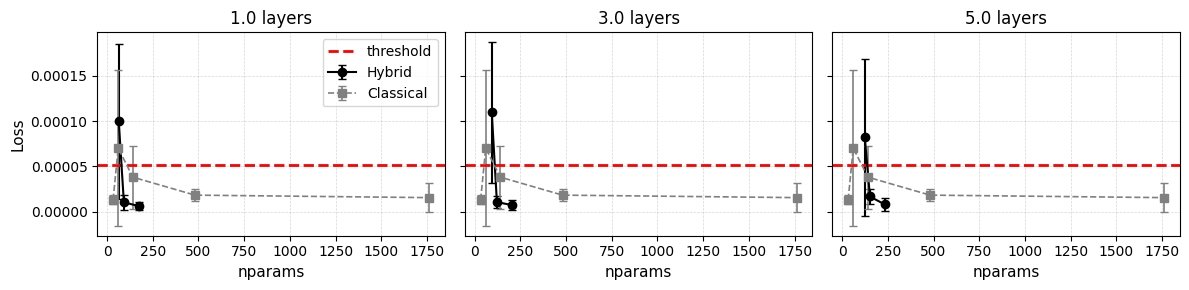

In [710]:
PARAM_COL = "num_params"   # ajuste se o nome for outro
blocks_fixed = 5           # <<< escolha o número de blocks que quer fixar
threshold = (1 / 140**2)

# ================================================================
# HYBRID
# ================================================================
df_nq = df_hybrid[df_hybrid["n_qubits"] == nq_fix].copy()
layers_list = sorted(df_nq["n_layers"].unique())

df_plot = df_nq[df_nq["blocks"] == blocks_fixed].copy()

grouped = (
    df_plot
    .groupby(["n_layers", "hidden"])[[PARAM_COL, LOSS_COLUMN]]
    .agg(["mean", "std"])
)
grouped.columns = ["param_mean", "param_std", "loss_mean", "loss_std"]

# ================================================================
# CLASSICAL (mesmo para todos os painéis)
# ================================================================
df_class_plot = df_class[df_class["blocks"] == blocks_fixed].copy()

grouped_class = (
    df_class_plot
    .groupby("hidden")[[PARAM_COL, LOSS_COLUMN]]
    .agg(["mean", "std"])
)
grouped_class.columns = ["param_mean", "param_std", "loss_mean", "loss_std"]
grouped_class = grouped_class.sort_values("param_mean")

x_c    = grouped_class["param_mean"].values
y_c    = grouped_class["loss_mean"].values
yerr_c = grouped_class["loss_std"].values

# ================================================================
# PLOTS
# ================================================================
n_panels = len(layers_list)
fig, axes = plt.subplots(
    1, n_panels,
    figsize=(4 * n_panels, 3),
    sharey=True
)

if n_panels == 1:
    axes = [axes]

for idx, (ax, nl) in enumerate(zip(axes, layers_list)):

    if nl not in grouped.index.get_level_values(0):
        ax.set_visible(False)
        continue

    sub = grouped.loc[nl]        # nível = hidden
    sub = sub.sort_values("param_mean")

    x    = sub["param_mean"].values
    y    = sub["loss_mean"].values
    yerr = sub["loss_std"].values

    # ------------------------------------------------------------
    # HYBRID CURVE
    # ------------------------------------------------------------
    ax.errorbar(
        x, y, yerr=yerr,
        fmt="-o",
        capsize=3,
        linewidth=1.5,
        markeredgewidth=1,
        color="black",
        label="Hybrid" if idx == 0 else "_nolegend_"
    )

    # ------------------------------------------------------------
    # CLASSICAL CURVE (igual em todos os painéis)
    # ------------------------------------------------------------
    ax.errorbar(
        x_c, y_c, yerr=yerr_c,
        fmt="--s",
        capsize=3,
        linewidth=1.2,
        markeredgewidth=1,
        color="gray",
        label="Classical" if idx == 0 else "_nolegend_"
    )

    # ------------------------------------------------------------
    # THRESHOLD horizontal line
    # ------------------------------------------------------------
    ax.axhline(
        y=threshold,
        color="red",
        linestyle="--",
        linewidth=2,
        label="threshold" if idx == 0 else "_nolegend_"
    )

    ax.set_title(f"{nl} layers", fontsize=12)
    ax.set_xlabel("nparams", fontsize=11)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

axes[0].set_ylabel("Loss", fontsize=11)
axes[0].legend()

plt.tight_layout()
plt.show()


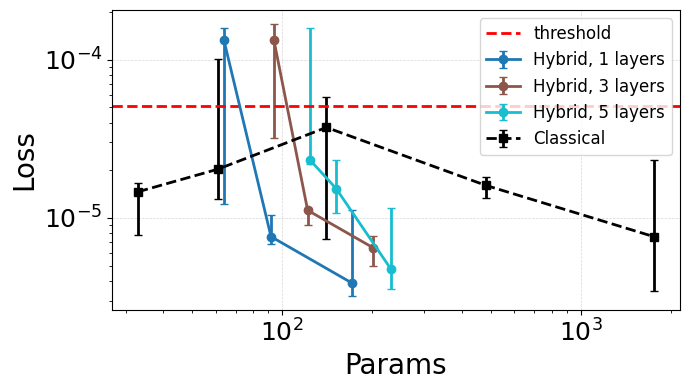

In [711]:
import numpy as np
import matplotlib.pyplot as plt

PARAM_COL    = "num_params"   # ajuste se o nome for outro
blocks_fixed = 5              # <<< número de blocks fixo
threshold    = (1 / 140**2)

# ============================
# Funções para quartis
# ============================
def q1(x):
    return np.percentile(x, 25)

def q3(x):
    return np.percentile(x, 75)

# ============================
# HYBRID (blocks fixo)
# ============================
# filtra só o nº de qubits que você quer
df_nq = df_hybrid[df_hybrid["n_qubits"] == nq_fix].copy()

# filtra pelo blocks fixo
df_plot = df_nq[df_nq["blocks"] == blocks_fixed].copy()

# valores de layers disponíveis com esse nº de qubits e blocks_fixed
layers_list = sorted(df_plot["n_layers"].unique())

# agrupa por (n_layers, hidden) e calcula mediana + Q1/Q3
grouped = (
    df_plot
    .groupby(["n_layers", "hidden"])[[PARAM_COL, LOSS_COLUMN]]
    .agg(
        param_median = (PARAM_COL, "median"),
        param_q1     = (PARAM_COL, q1),
        param_q3     = (PARAM_COL, q3),
        loss_median  = (LOSS_COLUMN, "median"),
        loss_q1      = (LOSS_COLUMN, q1),
        loss_q3      = (LOSS_COLUMN, q3),
    )
)

# ============================
# CLASSICAL (mesma curva, blocks fixo)
# ============================
df_class_plot = df_class[df_class["blocks"] == blocks_fixed].copy()

grouped_class = (
    df_class_plot
    .groupby("hidden")[[PARAM_COL, LOSS_COLUMN]]
    .agg(
        param_median = (PARAM_COL, "median"),
        param_q1     = (PARAM_COL, q1),
        param_q3     = (PARAM_COL, q3),
        loss_median  = (LOSS_COLUMN, "median"),
        loss_q1      = (LOSS_COLUMN, q1),
        loss_q3      = (LOSS_COLUMN, q3),
    )
)

grouped_class = grouped_class.sort_values("param_median")

x_c   = grouped_class["param_median"].values
y_c   = grouped_class["loss_median"].values
low_c = y_c - grouped_class["loss_q1"].values
upp_c = grouped_class["loss_q3"].values - y_c

# garante que nada fique negativo por erro numérico
low_c = np.maximum(low_c, 0.0)
upp_c = np.maximum(upp_c, 0.0)
yerr_c = np.vstack([low_c, upp_c])   # formato (2, N) para erro assimétrico

# ================================================================
# PLOTS — tudo em um único gráfico (MEDIANA + IQR)
# ================================================================
n_panels = len(layers_list)

fig, ax = plt.subplots(figsize=(7, 4))

# paleta de cores para distinguir cada número de layers
colors = plt.cm.tab10(np.linspace(0, 1, n_panels))

for nl, color in zip(layers_list, colors):

    if nl not in grouped.index.get_level_values(0):
        continue

    # índice interno = hidden  (pois agrupamos ["n_layers", "hidden"])
    sub = grouped.loc[nl]
    sub = sub.sort_values("param_median")

    # valores centrais
    x = sub["param_median"].values
    y = sub["loss_median"].values

    # erro inferior e superior: (mediana - Q1) e (Q3 - mediana)
    low = y - sub["loss_q1"].values
    upp = sub["loss_q3"].values - y

    # impedir valores negativos numéricos
    low = np.maximum(low, 0.0)
    upp = np.maximum(upp, 0.0)

    yerr = np.vstack([low, upp])   # erro assimétrico

    # ------------------------------------------------------------
    # CURVA HYBRID (MEDIAN + IQR)
    # ------------------------------------------------------------
    ax.errorbar(
        x, y, yerr=yerr,
        fmt="-o",
        capsize=3,
        linewidth=2,
        markeredgewidth=1,
        color=color,
        label=f"Hybrid, {int(nl)} layers"
    )

# ------------------------------------------------------------
# CURVA CLASSICAL (MEDIAN + IQR)
# ------------------------------------------------------------
ax.errorbar(
    x_c, y_c, yerr=yerr_c,
    fmt="--s",
    capsize=3,
    linewidth=2,
    markeredgewidth=1,
    color="black",
    label="Classical"
)

# ------------------------------------------------------------
# LINHA DE THRESHOLD
# ------------------------------------------------------------
ax.axhline(
    y=threshold,
    color="red",
    linestyle="--",
    linewidth=2,
    label="threshold"
)

ax.set_xlabel("Params", fontsize=20)
ax.set_ylabel("Loss", fontsize=20)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

ax.set_xscale("log")
ax.set_yscale("log")
ax.tick_params(axis="both", labelsize=18)

ax.legend(fontsize=12)
plt.tight_layout()
plt.savefig(f"weciq_hybrid_vs_classical_median_iqr_blocks{blocks_fixed}.png", dpi=300)
plt.show()


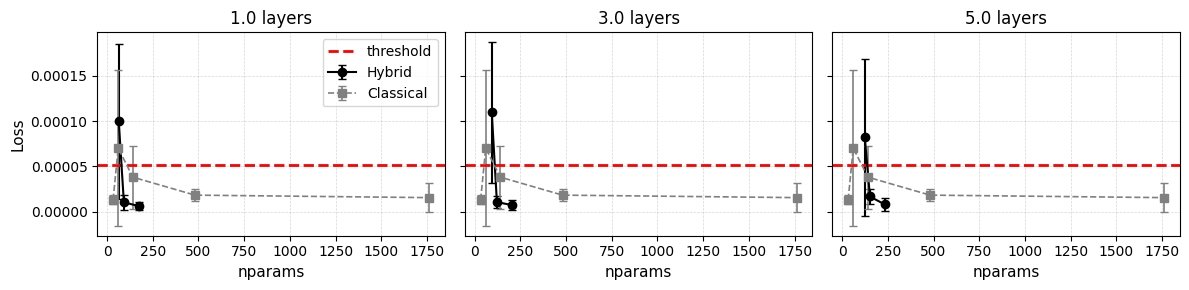

In [712]:
PARAM_COL = "num_params"   # ajuste se o nome for outro
blocks_fixed = 5           # <<< escolha o número de blocks que quer fixar
threshold = (1 / 140**2)

# ============================
# HYBRID
# ============================
# filtra só o nº de qubits que você quer
df_nq = df_hybrid[df_hybrid["n_qubits"] == nq_fix].copy()

# valores de layers disponíveis com esse nº de qubits
layers_list = sorted(df_nq["n_layers"].unique())

# filtra pelo blocks fixo
df_plot = df_nq[df_nq["blocks"] == blocks_fixed].copy()

# agrupa por (n_layers, hidden) e calcula média e desvio
grouped = (
    df_plot
    .groupby(["n_layers", "hidden"])[[PARAM_COL, LOSS_COLUMN]]
    .agg(["mean", "std"])
)
grouped.columns = ["param_mean", "param_std", "loss_mean", "loss_std"]

# ============================
# CLASSICAL (mesma curva em todos)
# ============================
df_class_plot = df_class[df_class["blocks"] == blocks_fixed].copy()

grouped_class = (
    df_class_plot
    .groupby("hidden")[[PARAM_COL, LOSS_COLUMN]]
    .agg(["mean", "std"])
)
grouped_class.columns = ["param_mean", "param_std", "loss_mean", "loss_std"]
grouped_class = grouped_class.sort_values("param_mean")

x_c    = grouped_class["param_mean"].values
y_c    = grouped_class["loss_mean"].values
yerr_c = grouped_class["loss_std"].values

# ============================
# PLOTS
# ============================
n_panels = len(layers_list)
fig, axes = plt.subplots(
    1, n_panels,
    figsize=(4 * n_panels, 3),
    sharey=True
)

if n_panels == 1:
    axes = [axes]

for idx, (ax, nl) in enumerate(zip(axes, layers_list)):
    if nl not in grouped.index.get_level_values(0):
        ax.set_visible(False)
        continue

    sub = grouped.loc[nl]        # índice = hidden
    sub = sub.sort_values("param_mean")

    x    = sub["param_mean"].values
    y    = sub["loss_mean"].values
    yerr = sub["loss_std"].values

    # --- HYBRID ---
    ax.errorbar(
        x, y, yerr=yerr,
        fmt="-o",
        capsize=3,
        linewidth=1.5,
        markeredgewidth=1,
        color="black",
        label="Hybrid" if idx == 0 else "_nolegend_"
    )

    # --- CLASSICAL (mesma curva em todos) ---
    ax.errorbar(
        x_c, y_c, yerr=yerr_c,
        fmt="--s",
        capsize=3,
        linewidth=1.2,
        markeredgewidth=1,
        color="gray",
        label="Classical" if idx == 0 else "_nolegend_"
    )

    # --- linha horizontal do threshold ---
    ax.axhline(
        y=threshold,
        color="red",
        linestyle="--",
        linewidth=2,
        label="threshold" if idx == 0 else "_nolegend_"
    )

    ax.set_title(f"{nl} layers", fontsize=12)
    ax.set_xlabel("nparams", fontsize=11)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

axes[0].set_ylabel("Loss", fontsize=11)
axes[0].legend()

plt.tight_layout()
plt.show()


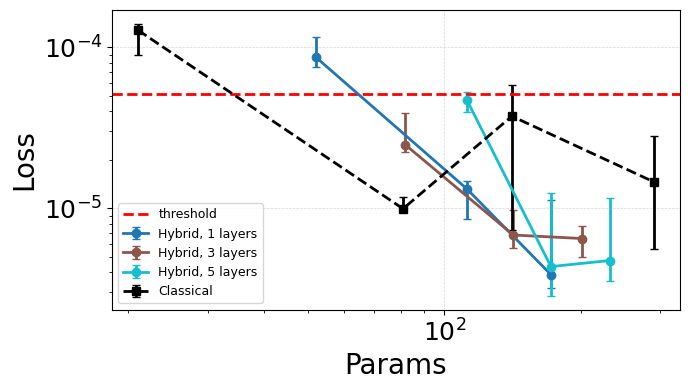

In [713]:
import numpy as np
import matplotlib.pyplot as plt

PARAM_COL    = "num_params"   # ajuste se o nome for outro
hidden_fixed = 5             # <<< número de neurônios fixo
threshold    = (1 / 140**2)

# ============================
# Funções para quartis
# ============================
def q1(x):
    return np.percentile(x, 25)

def q3(x):
    return np.percentile(x, 75)

# ============================
# HYBRID
# ============================
# filtra só o nº de qubits que você quer
df_nq = df_hybrid[df_hybrid["n_qubits"] == nq_fix].copy()

# filtra pelo hidden fixo
df_plot = df_nq[df_nq["hidden"] == hidden_fixed].copy()

# valores de layers disponíveis com esse nº de qubits e hidden
layers_list = sorted(df_plot["n_layers"].unique())

# agrupa por (n_layers, blocks) e calcula mediana + Q1/Q3
grouped = (
    df_plot
    .groupby(["n_layers", "blocks"])[[PARAM_COL, LOSS_COLUMN]]
    .agg(
        param_median = (PARAM_COL, "median"),
        param_q1     = (PARAM_COL, q1),
        param_q3     = (PARAM_COL, q3),
        loss_median  = (LOSS_COLUMN, "median"),
        loss_q1      = (LOSS_COLUMN, q1),
        loss_q3      = (LOSS_COLUMN, q3),
    )
)

# ============================
# CLASSICAL (mesma curva para todos)
# ============================
df_class_plot = df_class[df_class["hidden"] == hidden_fixed].copy()

grouped_class = (
    df_class_plot
    .groupby("blocks")[[PARAM_COL, LOSS_COLUMN]]
    .agg(
        param_median = (PARAM_COL, "median"),
        param_q1     = (PARAM_COL, q1),
        param_q3     = (PARAM_COL, q3),
        loss_median  = (LOSS_COLUMN, "median"),
        loss_q1      = (LOSS_COLUMN, q1),
        loss_q3      = (LOSS_COLUMN, q3),
    )
)

grouped_class = grouped_class.sort_values("param_median")

x_c   = grouped_class["param_median"].values
y_c   = grouped_class["loss_median"].values
low_c = y_c - grouped_class["loss_q1"].values
upp_c = grouped_class["loss_q3"].values - y_c

# garante que nada fique negativo por erro numérico
low_c = np.maximum(low_c, 0.0)
upp_c = np.maximum(upp_c, 0.0)
yerr_c = np.vstack([low_c, upp_c])   # formato (2, N) para erro assimétrico

# ============================
# PLOT ÚNICO
# ============================
fig, ax = plt.subplots(figsize=(7, 4))

# paleta de cores para cada número de layers
colors = plt.cm.tab10(np.linspace(0, 1, len(layers_list)))

for nl, color in zip(layers_list, colors):
    if nl not in grouped.index.get_level_values(0):
        continue

    # índice interno = blocks
    sub = grouped.loc[nl]
    sub = sub.sort_values("param_median")

    x   = sub["param_median"].values
    y   = sub["loss_median"].values
    low = y - sub["loss_q1"].values
    upp = sub["loss_q3"].values - y

    # clip para evitar negativos numéricos
    low = np.maximum(low, 0.0)
    upp = np.maximum(upp, 0.0)

    yerr = np.vstack([low, upp])   # erro assimétrico

    # --- HYBRID ---
    ax.errorbar(
        x, y, yerr=yerr,
        fmt="-o",
        capsize=3,
        linewidth=2,
        markeredgewidth=1,
        color=color,
        label=f"Hybrid, {int(nl)} layers"
    )

# --- CLASSICAL (mesma curva para todos) ---
ax.errorbar(
    x_c, y_c, yerr=yerr_c,
    fmt="--s",
    capsize=3,
    linewidth=2,
    markeredgewidth=1,
    color="black",
    label="Classical"
)

# --- linha horizontal do threshold ---
ax.axhline(
    y=threshold,
    color="red",
    linestyle="--",
    linewidth=2,
    label="threshold"
)

ax.set_xlabel("Params", fontsize=20)
ax.set_ylabel("Loss", fontsize=20)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)

ax.legend(fontsize=9)
ax.set_xscale("log")
ax.set_yscale("log")
ax.tick_params(axis="both", labelsize=18)
plt.tight_layout()
plt.savefig(f"weciq_hybrid_vs_classical_{hidden_fixed}.png", dpi=300)
plt.show()


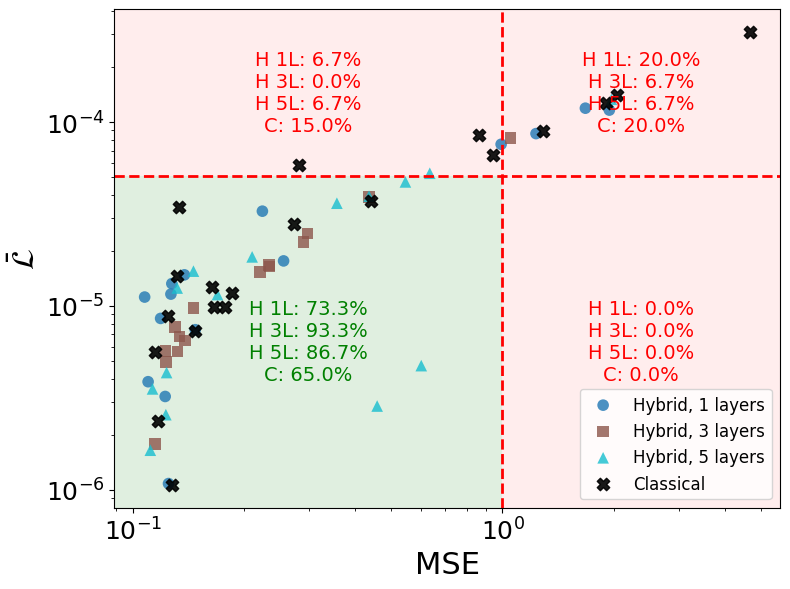

In [714]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ==========================
# CONFIGURAÇÕES
# ==========================
MSE_COLUMN = "mse_teste_desnormalizado"   # ajuste se o nome for outro
tx = 1.0                                  # threshold em MSE
ty = threshold                            # threshold em loss (já definido)

# ==========================
# FUNÇÃO → porcentagem por quadrante
# ==========================
def quadrant_percentages(x, y, tx, ty):
    total = len(x)
    if total == 0:
        return {q: 0.0 for q in ["Q1", "Q2", "Q3", "Q4"]}

    def pct(cond):
        return 100.0 * np.sum(cond) / total

    return {
        "Q1": pct((x >= tx) & (y >= ty)),   # cima-direita
        "Q2": pct((x <  tx) & (y >= ty)),   # cima-esquerda
        "Q3": pct((x <  tx) & (y <  ty)),   # baixo-esquerda (bom)
        "Q4": pct((x >= tx) & (y <  ty)),   # baixo-direita
    }

# ==========================
# DADOS
# ==========================
# Classical (mesmo conjunto para todos os layers)
x_c_all = df_class_plot[MSE_COLUMN].values
y_c_all = df_class_plot[LOSS_COLUMN].values
pct_c   = quadrant_percentages(x_c_all, y_c_all, tx, ty)

# Hybrid separado por layer
pct_h_layers = {}
for nl in layers_list:
    df_layer = df_plot[df_plot["n_layers"] == nl]
    x_h = df_layer[MSE_COLUMN].values
    y_h = df_layer[LOSS_COLUMN].values
    pct_h_layers[nl] = quadrant_percentages(x_h, y_h, tx, ty)

# ==========================
# PLOT ÚNICO
# ==========================
fig, ax = plt.subplots(figsize=(8, 6))

# paleta de cores por layer (para os pontos Hybrid)
colors = plt.cm.tab10(np.linspace(0, 1, len(layers_list)))

# marcadores diferentes para cada layer
markers = ["o", "s", "^", "D", "P", "X", "*", "v", "<", ">"]

# scatter Hybrid por layer
for (nl, color, marker) in zip(layers_list,
                               colors,
                               [markers[i % len(markers)] for i in range(len(layers_list))]):
    df_layer = df_plot[df_plot["n_layers"] == nl]
    x_h = df_layer[MSE_COLUMN].values
    y_h = df_layer[LOSS_COLUMN].values

    ax.scatter(
        x_h, y_h,
        label=f"Hybrid, {int(nl)} layers",
        alpha=0.8,
        s=70,
        color=color,
        marker=marker,
        edgecolor="none"
    )

# scatter Classical (todos juntos) – marker distinto
ax.scatter(
    x_c_all, y_c_all,
    label="Classical",
    alpha=0.9,
    s=80,
    color="black",
    marker="X"
)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel("MSE", fontsize=22)
ax.set_ylabel(r"$\bar{\mathcal{L}}$", fontsize=22)
ax.tick_params(axis="both", labelsize=18)

# linhas de threshold
ax.axhline(ty, color='red', linestyle='--', linewidth=2)
ax.axvline(tx, color='red', linestyle='--', linewidth=2)

# limites após plotar
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

# ==========================
# QUADRANTES COLORIDOS
# ==========================
ax.add_patch(Rectangle((x_min, y_min), tx - x_min, ty - y_min,
                       facecolor='green', alpha=0.12, zorder=0))
ax.add_patch(Rectangle((x_min, ty), tx - x_min, y_max - ty,
                       facecolor='red', alpha=0.07, zorder=0))
ax.add_patch(Rectangle((tx, y_min), x_max - tx, ty - y_min,
                       facecolor='red', alpha=0.07, zorder=0))
ax.add_patch(Rectangle((tx, ty), x_max - tx, y_max - ty,
                       facecolor='red', alpha=0.07, zorder=0))

# ==========================
# TEXTO COM PORCENTAGENS
# ==========================
def mid_log(a, b):
    return 10**((np.log10(a) + np.log10(b)) / 2)

xL = mid_log(x_min, tx)
xR = mid_log(tx,   x_max)
yB = mid_log(y_min, ty)
yT = mid_log(ty,    y_max)

def build_text(quadrant):
    lines = []
    # Hybrid por layer
    for nl in layers_list:
        lines.append(f"H {int(nl)}L: {pct_h_layers[nl][quadrant]:.1f}%")
    # Classical agregado
    lines.append(f"C: {pct_c[quadrant]:.1f}%")
    return "\n".join(lines)

# Q3 (baixo-esquerda, bom)
ax.text(
    xL, yB,
    build_text("Q3"),
    color='green', fontsize=14,
    ha='center', va='center'
)

# Q2 (cima-esquerda)
ax.text(
    xL, yT,
    build_text("Q2"),
    color='red', fontsize=14,
    ha='center', va='center'
)

# Q4 (baixo-direita)
ax.text(
    xR, yB,
    build_text("Q4"),
    color='red', fontsize=14,
    ha='center', va='center'
)

# Q1 (cima-direita)
ax.text(
    xR, yT,
    build_text("Q1"),
    color='red', fontsize=14,
    ha='center', va='center'
)
ax.legend(fontsize=12, loc="lower right")
plt.tight_layout()
plt.savefig(f"quadrants_all_layers_hidden{hidden_fixed}.png", dpi=300)
plt.show()


In [715]:
bse = BlackScholes(eps=1e-10)
data = bse.generate_data()
data_teste = bse.generate_data(seed=2025)

Melhor modelo encontrado:
model_type                                                               HQNN
run_id_prefix                                                 hqnn_strong_mlp
model_class                                                               MLP
activation                                                             Tanh()
lr                                                                      0.002
epochs                                                                15000.0
entangler                                                              strong
hidden                                                                    2.0
blocks                                                                    5.0
n_qubits                                                                  3.0
n_layers                                                                  1.0
seed                                                                   1924.0
run_id                      hqnn_stron

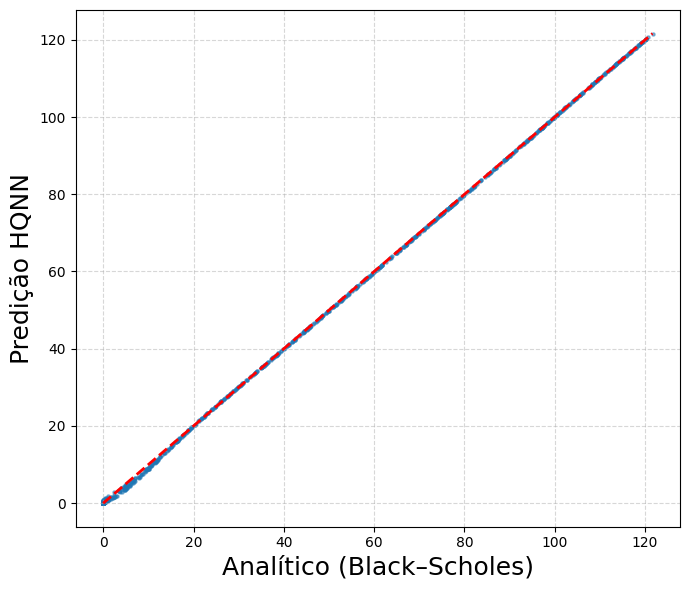

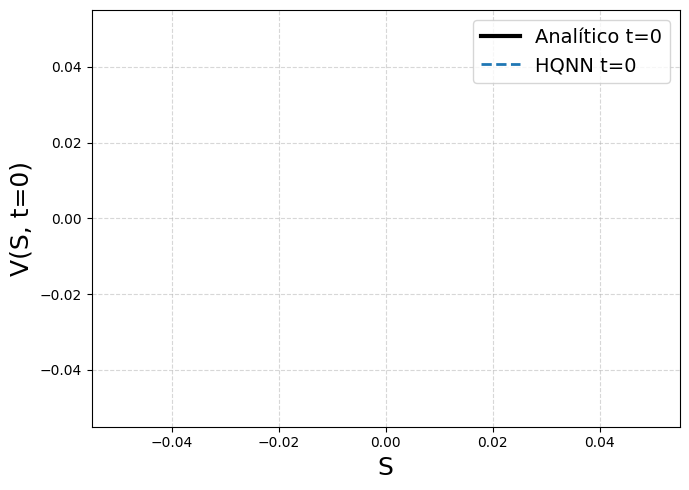

In [722]:
import os
import numpy as np
import pandas as pd
import torch as tc
import torch.nn as nn
import matplotlib.pyplot as plt

# ==============================
# IMPORTS DO SEU PROJETO
# ==============================
from equation.option_pricing import BlackScholes
from optimize.option_princing import BlackScholeOptimizer
from method.nn import MLP, ResNet
from method.hnn import HybridCQN
from method.qnn import QuantumNeuralNetwork

# Caminho do sumário híbrido (ajuste se precisar)
SUMMARY_HYBRID_PATH = "./experimentos_pinn/sumario_hibrido.csv"

device = "cuda" if tc.cuda.is_available() else "cpu"

# ==============================
# 1) CARREGAR O MELHOR MODELO
# ==============================
df_h = pd.read_csv(SUMMARY_HYBRID_PATH)

# Critério de “melhor”: menor MSE desnormalizado
best = df_h.sort_values("mse_teste_desnormalizado").iloc[0]

print("Melhor modelo encontrado:")
print(best)
model_path = best["model_path"]
print(f"\nCarregando pesos de: {model_path}")

# ==============================
# 2) RECONSTRUIR A ARQUITETURA
# ==============================
hidden   = int(best["hidden"])
blocks   = int(best["blocks"])
n_qubits = int(best["n_qubits"])
n_layers = int(best["n_layers"])
entangler = best.get("entangler", "strong")  # você usou 'strong'

activation = nn.Tanh()

# bloco quântico
qnn = QuantumNeuralNetwork(
    n_qubits=n_qubits,
    n_layers=n_layers,
    device=device,
    entangler=entangler,
)

# bloco clássico (MLP no caso da linha que você mostrou)
if best["model_class"] == "MLP":
    model_c = MLP(
        hidden=hidden,
        blocks=blocks,
        device=device,
        activation=activation
    )
else:
    model_c = ResNet(
        hidden=hidden,
        blocks=blocks,
        device=device,
        activation=activation
    )

# modelo híbrido completo
model = HybridCQN(
    classical_pre=model_c,
    qnn_block=qnn,
    classical_post=None,
    device=device,
)

# carregar pesos
state_dict = tc.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

# ==============================
# 3) GERAR DADOS ANALÍTICOS
# ==============================
bse = BlackScholes(eps=1e-10)

# dados “de treino” (pode ser o padrão, sem seed)
data = bse.generate_data()

# dados de teste, como você pediu
data_teste = bse.generate_data(seed=2025)

# ==============================
# 4) CRIAR OTIMIZADOR SÓ PARA USAR .test()
# ==============================
# lr / epochs aqui não importam para inferência, mas
# usamos algo consistente com o treino para ficar limpo
lr     = float(best["lr"])
epochs = int(best["epochs"])
weights = [1, 1, 1, 1]   # ou recupere do CSV se você tiver essa coluna

opt = BlackScholeOptimizer(
    data,            # mesmo formato que no treino
    model, 
    epochs=epochs,
    lr=lr,
    device=device,
    weights=weights
)

# ==============================
# 5) TESTE (MSE + PREDIÇÕES)
# ==============================
# Aqui dependemos da assinatura do seu .test:
# no treino você usou:
#   mse_norm, mse_unorm, _ = opt.test(data_teste, return_unormalized=True)
mse_norm, mse_unorm, preds = opt.test(
    data_teste,
    return_unormalized=True
)

print(f"\nMSE normalizado  (teste): {mse_norm:.6e}")
print(f"MSE desnormalizado (teste): {mse_unorm:.6e}")

# ==============================
# 6) PEGAR VALORES ANALÍTICOS PARA COMPARAR
# ==============================
# Supondo que data_teste['domain'] = (S_domain, t_domain, v_domain, V_domain)
S_dom, t_dom, V_dom = data_teste["domain"]

# preds deve estar no mesmo ordenamento dos pontos de domínio;
# se seu .test retorna algo diferente, basta adaptar aqui.
V_pred = preds["domain"] if isinstance(preds, dict) else preds

# ==============================
# 7) PLOTS: ANALÍTICO vs PREDITO
# ==============================

# --- scatter V_analítico vs V_predito ---
plt.figure(figsize=(7, 6))
plt.scatter(V_dom, V_pred, s=5, alpha=0.5)
vmin = min(V_dom.min(), V_pred.min())
vmax = max(V_dom.max(), V_pred.max())
plt.plot([vmin, vmax], [vmin, vmax], "r--", linewidth=2)
plt.xlabel("Analítico (Black–Scholes)", fontsize=18)
plt.ylabel("Predição HQNN", fontsize=18)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("comparacao_analitico_vs_hqnn_scatter.png", dpi=300)
plt.show()

# --- curva em t = 0 (por exemplo) como função de S ---
# filtra pontos próximos de t=0 (ou outro corte)
mask_t0 = np.isclose(t_dom, 0.0, atol=1e-3)
S_t0    = S_dom[mask_t0]
V_true_t0 = V_dom[mask_t0]
V_pred_t0 = V_pred[mask_t0]

idx_sort = np.argsort(S_t0)
S_t0        = S_t0[idx_sort]
V_true_t0   = V_true_t0[idx_sort]
V_pred_t0   = V_pred_t0[idx_sort]

plt.figure(figsize=(7, 5))
plt.plot(S_t0, V_true_t0, label="Analítico t=0", linewidth=3, color="black")
plt.plot(S_t0, V_pred_t0, "--", label="HQNN t=0", linewidth=2)
plt.xlabel("S", fontsize=18)
plt.ylabel("V(S, t=0)", fontsize=18)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("comparacao_analitico_vs_hqnn_t0.png", dpi=300)
plt.show()
